#### Auteur: Irina Maslowski

### Projet N° 4. Segmentez des clients d'un site e-commerce

#### Données: [Brazilian E-Commerce Public Dataset by Olist. 100,000 Orders with product, customer and reviews info](https://www.kaggle.com/olistbr/brazilian-ecommerce)
années: 2016 - 2018

## Taches:
1. créer les meilleures features pour les exploiter à partir de données dans notre disposition
2. utiliserez des méthodes non supervisées pour regrouper ensemble des clients de profils similaires
**Cahier des charges** :
1. La segmentation proposée doit être exploitable et facile d’utilisation pour l’équipe marketing.
2. Evaluez la fréquence à laquelle la segmentation doit être mise à jour, 
afin de pouvoir effectuer un devis de contrat de maintenance.
3. Le code fourni doit respecter la convention PEP8, pour être utilisable par Olist.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
# EXEMPLE sur http://www.python-simple.com/python-statsmodels/statsmodels-anova.php
import statsmodels.formula.api
import statsmodels.api

In [2]:
import datetime as dt

## Sommaire:
* [Import des données](#first-bullet)
* [Création de nouvelles variables](#new_var)
    * [Temps depuis la commande](#delta_date_order)
    * [Distance entre le client et le vendeur](#customer_seller_distance)
    * [Changement de format pour datetime](#to_datetime)
    * [Durée de livraison](#delivery_period)
    * [Colonnes par type de status de la commande](#order_status)
    * [La volume des produits](#product_volume)
    * [Livraison à temps](#intime_delivery)
* [Analyse](#analisys)

# Import des données <a class="anchor" id="first-bullet"></a>

In [3]:
df_olist_ecommerce = pd.read_csv('C:/Users/piari/Documents/Projet4_ecommerce/df_olist_total.csv', encoding='utf-8', low_memory=False)
df_olist_ecommerce.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,product_category_name,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_creation_date,review_answer_timestamp,contain_message
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,housewares,1.0,credit_card,1.0,18.12,a54f0611adc9ed256b57ede6b6eb5114,4,2017-10-11 00:00:00,2017-10-12 03:43:48,True
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,housewares,3.0,voucher,1.0,2.00,a54f0611adc9ed256b57ede6b6eb5114,4,2017-10-11 00:00:00,2017-10-12 03:43:48,True
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,housewares,2.0,voucher,1.0,18.59,a54f0611adc9ed256b57ede6b6eb5114,4,2017-10-11 00:00:00,2017-10-12 03:43:48,True
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,...,perfumery,1.0,boleto,1.0,141.46,8d5266042046a06655c8db133d120ba5,4,2018-08-08 00:00:00,2018-08-08 18:37:50,True
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,auto,1.0,credit_card,3.0,179.12,e73b67b67587f7644d5bd1a52deb1b01,5,2018-08-18 00:00:00,2018-08-22 19:07:58,False


In [4]:
df_olist_ecommerce.shape

(119151, 42)

In [5]:
df_olist_ecommerce.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119151 entries, 0 to 119150
Data columns (total 42 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       119151 non-null  object 
 1   customer_id                    119151 non-null  object 
 2   order_status                   119151 non-null  object 
 3   order_purchase_timestamp       119151 non-null  object 
 4   order_approved_at              118974 non-null  object 
 5   order_delivered_carrier_date   117065 non-null  object 
 6   order_delivered_customer_date  115730 non-null  object 
 7   order_estimated_delivery_date  119151 non-null  object 
 8   customer_unique_id             119151 non-null  object 
 9   customer_zip_code_prefix       119151 non-null  int64  
 10  customer_city                  119151 non-null  object 
 11  customer_state                 119151 non-null  object 
 12  customer_lat                  

# Création de nouvelles variables <a class="anchor" id="new_var"></a>

## Temps depuis la commande <a class="anchor" id="delta_date_order"></a>

In [6]:
df_olist_ecommerce['order_purchase_timestamp'].max()

'2018-10-17 17:30:18'

In [7]:
df_olist_ecommerce['order_delivered_customer_date'].isna().sum()

3421

In [8]:
max_date = pd.to_datetime(df_olist_ecommerce['order_purchase_timestamp']).max()

In [9]:
max_date

Timestamp('2018-10-17 17:30:18')

In [10]:
df_olist_ecommerce['delta_date_order'] = max_date - pd.to_datetime(df_olist_ecommerce['order_purchase_timestamp'])

In [11]:
df_olist_ecommerce.groupby('customer_unique_id').agg({
    'delta_date_order':'min',
    'order_purchase_timestamp': ('min', 'max'),
    'price': ('min', 'max', 'mean'),
})

delta_date_order order_purchase_timestamp  \
                                               min                      min   
customer_unique_id                                                            
0000366f3b9a7992bf8c76cfdf3221e2 160 days 06:33:51      2018-05-10 10:56:27   
0000b849f77a49e4a4ce2b2a4ca5be3f 163 days 06:18:51      2018-05-07 11:11:27   
0000f46a3911fa3c0805444483337064 585 days 20:25:15      2017-03-10 21:05:03   
0000f6ccb0745a6a4b88665a16c9f078 369 days 21:00:37      2017-10-12 20:29:41   
0004aac84e0df4da2b147fca70cf8255 336 days 21:44:36      2017-11-14 19:45:42   
...                                            ...                      ...   
fffcf5a5ff07b0908bd4e2dbc735a684 495 days 20:29:42      2017-06-08 21:00:36   
fffea47cd6d3cc0a88bd621562a9d061 310 days 21:22:22      2017-12-10 20:07:56   
ffff371b4d645b6ecea244b27531430a 617 days 01:41:02      2017-02-07 15:49:16   
ffff5962728ec6157033ef9805bacc48 168 days 02:12:37      2018-05-02 15:17:41   
ffffd2657e2aad2907e67c3e9daecbeb 532 days 21:11:33      2017-05-02 20:18:45   

                                                        price                  
                                                  max     min     max    mean  
customer_unique_id                                                             
0000366f3b9a7992bf8c76cfdf3221e2  2018-05-10 10:56:27  129.90  129.90  129.90  
0000b849f77a49e4a4ce2b2a4ca5be3f  2018-05-07 11:11:27   18.90   18.90   18.90  
0000f46a3911fa3c0805444483337064  2017-03-10 21:05:03   69.00   69.00   69.00  
0000f6ccb0745a6a4b88665a16c9f078  2017-10-12 20:29:41   25.99   25.99   25.99  
0004aac84e0df4da2b147fca70cf8255  2017-11-14 19:45:42  180.00  180.00  180.00  
...                                               ...     ...     ...     ...  
fffcf5a5ff07b0908bd4e2dbc735a684  2017-06-08 21:00:36  680.00  890.00  785.00  
fffea47cd6d3cc0a88bd621562a9d061  2017-12-10 20:07:56   64.89   64.89   64.89  
ffff371b4d645b6ecea244b27531430a  2017-02-07 15:49:16   89.90   89.90   89.90  
ffff5962728ec6157033ef9805bacc48  2018-05-02 15:17:41  115.00  115.00  115.00  
ffffd2657e2aad2907e67c3e9daecbeb  2017-05-02 20:18:45   56.99   56.99   56.99  

[96096 rows x 6 columns]

In [12]:
df_olist_ecommerce.groupby('customer_unique_id').agg({'delta_date_order':'min'}).describe()

,delta_date_order
count,96096
mean,288 days 04:49:58.344135112
std,153 days 09:59:29.882079690
min,0 days 00:00:00
25%,163 days 21:15:28.250000
50%,268 days 21:51:02
75%,397 days 08:26:00.750000
max,772 days 20:14:59


## Distance entre le client et le vendeur <a class="anchor" id="customer_seller_distance"></a>

In [13]:
# https://stackoverflow.com/questions/40452759/pandas-latitude-longitude-to-distance-between-successive-rows
# vectorized haversine function
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    """
    slightly modified version: of http://stackoverflow.com/a/29546836/2901002

    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)

    All (lat, lon) coordinates must have numeric dtypes and be of equal length.

    """
    lat2 = float(lat2)
    lon2 = float(lon2)
    lat1 = float(lat1)
    lon1 = float(lon1)
    if to_radians:
        try:
            lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])
        except:
            print([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))

In [14]:
# distance en kilomètres
df_olist_ecommerce['customer_seller_distance'] = df_olist_ecommerce.apply(lambda x:haversine(x['customer_lat'],x['customer_lng'], x['seller_lat'], x['seller_lng']), axis=1)

In [15]:
df_olist_ecommerce['customer_seller_distance'].describe()

count    118318.000000
mean        598.179773
std         590.295692
min           0.000000
25%         188.423272
50%         433.347832
75%         794.485352
max        8677.898938
Name: customer_seller_distance, dtype: float64

In [16]:
df_olist_ecommerce.describe()

,customer_zip_code_prefix,customer_lat,customer_lng,order_item_id,price,freight_value,seller_zip_code_prefix,seller_lat,seller_lng,product_name_lenght,...,product_weight_g,product_length_cm,product_height_cm,product_width_cm,payment_sequential,payment_installments,payment_value,review_score,delta_date_order,customer_seller_distance
count,119151.000000,119151.000000,119151.000000,118318.000000,118318.000000,118318.000000,118318.000000,118318.000000,118318.000000,116609.000000,...,118298.000000,118298.000000,118298.000000,118298.000000,119148.000000,119148.000000,119148.000000,119151.000000,119151,118318.000000
mean,35033.953253,-21.216282,-46.191418,1.196530,120.649109,20.032587,24442.245322,-22.794262,-47.238218,48.767402,...,2112.302803,30.264865,16.619994,23.074896,1.094731,2.941426,172.735670,3.998514,291 days 22:58:35.296498060,598.179773
std,29823.224176,5.572841,4.053372,0.699467,184.107686,15.836559,27572.843192,2.690999,2.337575,10.033526,...,3786.673988,16.188992,13.453771,11.749216,0.730117,2.777992,267.770023,1.412529,153 days 16:35:58.831222270,590.295692
min,1003.000000,-33.690729,-72.670621,1.000000,0.850000,0.000000,1001.000000,-32.073840,-67.812015,5.000000,...,0.000000,7.000000,2.000000,6.000000,1.000000,0.000000,0.000000,1.000000,0 days 00:00:00,0.000000
25%,11250.000000,-23.589239,-48.079106,1.000000,39.900000,13.080000,6429.000000,-23.606097,-48.829262,42.000000,...,300.000000,18.000000,8.000000,15.000000,1.000000,1.000000,60.850000,3.000000,167 days 04:19:03,188.423272
50%,24240.000000,-22.926331,-46.632651,1.000000,74.900000,16.280000,13660.000000,-23.423346,-46.744318,52.000000,...,700.000000,25.000000,13.000000,20.000000,1.000000,2.000000,108.160000,5.000000,273 days 05:31:06,433.347832
75%,58475.000000,-20.140685,-43.614888,1.000000,134.900000,21.180000,27972.000000,-21.757538,-46.520839,57.000000,...,1800.000000,38.000000,20.000000,30.000000,1.000000,4.000000,189.240000,5.000000,401 days 21:14:32,794.485352
max,99990.000000,42.184003,37.830233,21.000000,6735.000000,409.680000,99730.000000,-2.501703,-34.855504,76.000000,...,40425.000000,105.000000,105.000000,118.000000,29.000000,24.000000,13664.080000,5.000000,772 days 20:14:59,8677.898938


In [17]:
df_olist_ecommerce.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 177
order_delivered_carrier_date     2086
order_delivered_customer_date    3421
order_estimated_delivery_date       0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
customer_lat                        0
customer_lng                        0
order_item_id                     833
product_id                        833
seller_id                         833
shipping_limit_date               833
price                             833
freight_value                     833
seller_zip_code_prefix            833
seller_city                       833
seller_state                      833
seller_lat                        833
seller_lng                        833
product_name_lenght              2542
product_desc

In [18]:
df_olist_ecommerce.drop(['customer_lat', 'customer_lng', 'seller_lat', 'seller_lng'], axis=1, inplace=True)

In [19]:
df_olist_ecommerce.shape

(119151, 40)

In [20]:
# nbre d'achats en fonction de distance
df_olist_ecommerce['customer_seller_distance_inferior50km'] = df_olist_ecommerce['customer_seller_distance'] <= 50

In [21]:
df_olist_ecommerce['customer_seller_distance_51km-100km'] = ((df_olist_ecommerce['customer_seller_distance'] > 50) & (df_olist_ecommerce['customer_seller_distance'] <= 100))

In [22]:
df_olist_ecommerce['customer_seller_distance_101km-1000km'] = ((df_olist_ecommerce['customer_seller_distance'] > 100) & (df_olist_ecommerce['customer_seller_distance'] <= 1000))

In [23]:
df_olist_ecommerce['customer_seller_distance_1001km_plus'] = df_olist_ecommerce['customer_seller_distance'] > 1000

## Changement de format pour datetime <a class="anchor" id="to_datetime"></a>

In [24]:
df_olist_ecommerce['order_delivered_customer_date'] = pd.to_datetime(df_olist_ecommerce['order_delivered_customer_date'])

In [25]:
df_olist_ecommerce['order_purchase_timestamp'] = pd.to_datetime(df_olist_ecommerce['order_purchase_timestamp'])

## Durée de livraison <a class="anchor" id="delivery_period"></a>

In [26]:
df_olist_ecommerce['delivery_period'] = df_olist_ecommerce['order_delivered_customer_date'] - df_olist_ecommerce['order_purchase_timestamp']

In [27]:
df_olist_ecommerce['delivery_period']

0         8 days 10:28:40
1         8 days 10:28:40
2         8 days 10:28:40
3        13 days 18:46:08
4         9 days 09:27:40
               ...       
119146   22 days 04:38:58
119147   24 days 20:37:34
119148   17 days 02:04:27
119149   17 days 02:04:27
119150    7 days 16:11:00
Name: delivery_period, Length: 119151, dtype: timedelta64[ns]

## Colonnes par type de status de la commande <a class="anchor" id="order_status"></a>

In [28]:
df_olist_ecommerce[df_olist_ecommerce['order_delivered_customer_date'].isna()]['order_status'].unique()

array(['invoiced', 'shipped', 'processing', 'unavailable', 'canceled',
       'delivered', 'created', 'approved'], dtype=object)

In [29]:
df_olist_ecommerce['order_status'].unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

In [30]:
order_status_dico = {
    'delivered' : ['delivered'],
    'in_progress' : ['invoiced', 'shipped', 'processing', 'created', 'approved'],
    'unavailable' : ['unavailable'],
    'canceled' : ['canceled']
}

In [31]:
for column_name, column_values in order_status_dico.items():
    df_olist_ecommerce[column_name]=df_olist_ecommerce['order_status'].isin(column_values)

In [32]:
df_olist_ecommerce[df_olist_ecommerce['in_progress'] == True]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,customer_seller_distance,customer_seller_distance_inferior50km,customer_seller_distance_51km-100km,customer_seller_distance_101km-1000km,customer_seller_distance_1001km_plus,delivery_period,delivered,in_progress,unavailable,canceled
8,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaN,NaT,2017-05-09 00:00:00,36edbb3fb164b1f16485364b6fb04c73,98900,...,914.067122,False,False,True,False,NaT,False,True,False,False
51,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28 00:00:00,08fb46d35bb3ab4037202c23592d1259,13215,...,104.488492,False,False,True,False,NaT,False,True,False,False
125,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaN,NaT,2018-08-21 00:00:00,c7f8d7b1fffc946d7069574f74c39f4e,88140,...,514.304875,False,False,True,False,NaT,False,True,False,False
155,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaN,NaT,2017-10-03 00:00:00,9f269af9c49244f6ba4a46985a3cfc2e,3436,...,524.118861,False,False,True,False,NaT,False,True,False,False
192,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaT,2018-02-07 00:00:00,528b011eb7fab3d59c336cc7248eed3a,38600,...,716.472758,False,False,True,False,NaT,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118754,274a7f7e4f1c17b7434a830e9b8759b1,670af30ca5b8c20878fecdafa5ee01b9,shipped,2018-06-23 13:25:15,2018-06-23 13:40:11,2018-07-04 13:51:00,NaT,2018-07-24 00:00:00,8823bc1bf8b46bec53f2b6e7c5d0a8c0,49030,...,1720.026017,False,False,False,True,NaT,False,True,False,False
118755,274a7f7e4f1c17b7434a830e9b8759b1,670af30ca5b8c20878fecdafa5ee01b9,shipped,2018-06-23 13:25:15,2018-06-23 13:40:11,2018-07-04 13:51:00,NaT,2018-07-24 00:00:00,8823bc1bf8b46bec53f2b6e7c5d0a8c0,49030,...,1720.026017,False,False,False,True,NaT,False,True,False,False
118787,aea0db338150b526dde24f6fd953a5ed,379a02efdc6a56bd27f99b95fc2f6c06,processing,2017-12-26 21:56:13,2017-12-26 22:05:26,NaN,NaT,2018-01-26 00:00:00,43fb4e33ebe4ac765e99c7b57e5d6940,79200,...,1014.834281,False,False,False,True,NaT,False,True,False,False
118840,636cdd02667dc8d76d9296bf20a6890a,c162256b133c76f79181ce61d66545db,shipped,2018-02-17 14:31:22,2018-02-20 07:11:31,2018-02-20 19:18:58,NaT,2018-03-14 00:00:00,39552b92919b5aacffcd326b13af0397,12042,...,234.419691,False,False,True,False,NaT,False,True,False,False


## La volume des produits <a class="anchor" id="product_volume"></a>

In [33]:
df_olist_ecommerce['product_volume_cm3'] = (df_olist_ecommerce['product_length_cm']/100) * (df_olist_ecommerce['product_height_cm']/100) * (df_olist_ecommerce['product_width_cm']/100)

In [34]:
df_olist_ecommerce['product_volume_cm3'].describe()

count    118298.000000
mean          0.015378
std           0.023653
min           0.000168
25%           0.002856
50%           0.006600
75%           0.018502
max           0.296208
Name: product_volume_cm3, dtype: float64

In [35]:
df_olist_ecommerce.drop(['product_length_cm', 'product_height_cm', 'product_width_cm'], axis=1, inplace=True)

## Livraison à temps <a class="anchor" id="intime_delivery"></a>

In [36]:
df_olist_ecommerce['shipping_limit_date'] = pd.to_datetime(df_olist_ecommerce['shipping_limit_date'])

In [37]:
df_olist_ecommerce['order_estimated_delivery_date'] = pd.to_datetime(df_olist_ecommerce['order_estimated_delivery_date'])

In [38]:
df_olist_ecommerce['intime_shipping'] = df_olist_ecommerce['shipping_limit_date'] - df_olist_ecommerce['order_delivered_customer_date']

In [39]:
df_olist_ecommerce['intime_delivery'] = df_olist_ecommerce['order_estimated_delivery_date'] - df_olist_ecommerce['order_delivered_customer_date']

In [40]:
df_olist_ecommerce['intime_delivery'].describe()

count                        115730
mean     11 days 08:27:06.043938490
std      10 days 03:59:30.897174294
min             -189 days +00:35:53
25%                 6 days 12:11:26
50%         12 days 01:21:19.500000
75%                16 days 07:34:48
max               146 days 00:23:13
Name: intime_delivery, dtype: object

In [41]:
df_olist_ecommerce.drop(['intime_shipping'], axis=1, inplace=True)

In [42]:
df_olist_ecommerce.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119151 entries, 0 to 119150
Data columns (total 48 columns):
 #   Column                                 Non-Null Count   Dtype          
---  ------                                 --------------   -----          
 0   order_id                               119151 non-null  object         
 1   customer_id                            119151 non-null  object         
 2   order_status                           119151 non-null  object         
 3   order_purchase_timestamp               119151 non-null  datetime64[ns] 
 4   order_approved_at                      118974 non-null  object         
 5   order_delivered_carrier_date           117065 non-null  object         
 6   order_delivered_customer_date          115730 non-null  datetime64[ns] 
 7   order_estimated_delivery_date          119151 non-null  datetime64[ns] 
 8   customer_unique_id                     119151 non-null  object         
 9   customer_zip_code_prefix             

In [43]:
# 0000366f3b9a7992bf8c76cfdf3221e2
df_olist_ecommerce[df_olist_ecommerce['customer_unique_id'] == '0000366f3b9a7992bf8c76cfdf3221e2']

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,customer_seller_distance_51km-100km,customer_seller_distance_101km-1000km,customer_seller_distance_1001km_plus,delivery_period,delivered,in_progress,unavailable,canceled,product_volume_cm3,intime_delivery
63200,e22acc9c116caa3f2b7121bbb380d08e,fadbb3709178fc513abc1b2670aa1ad2,delivered,2018-05-10 10:56:27,2018-05-10 11:11:18,2018-05-12 08:18:00,2018-05-16 20:48:37,2018-05-21,0000366f3b9a7992bf8c76cfdf3221e2,7787,...,False,True,False,6 days 09:52:10,True,False,False,False,0.007616,4 days 03:11:23


In [44]:
df_olist_ecommerce['payment_installments'].describe()

count    119148.000000
mean          2.941426
std           2.777992
min           0.000000
25%           1.000000
50%           2.000000
75%           4.000000
max          24.000000
Name: payment_installments, dtype: float64

# Analyse <a class="anchor" id="analisys"></a>

In [45]:
categ = ['customer_state', 'seller_state', 'product_category_name', 'payment_type', 'review_score', 'order_status', 'delivered', 'in_progress', 'unavailable', 'canceled']

'customer_state'

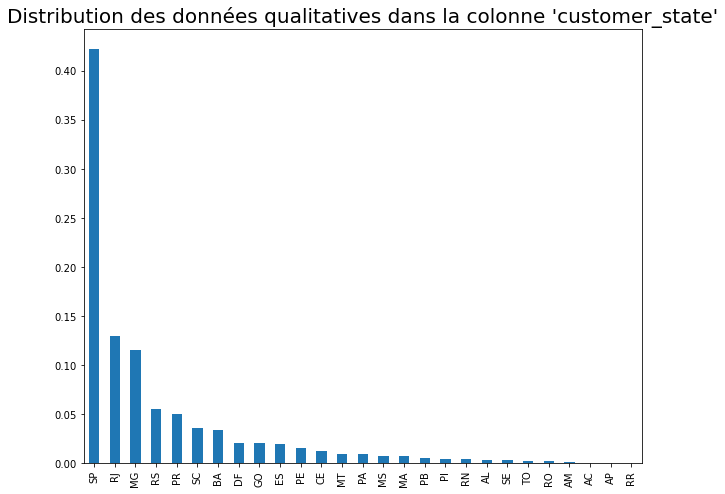

'seller_state'

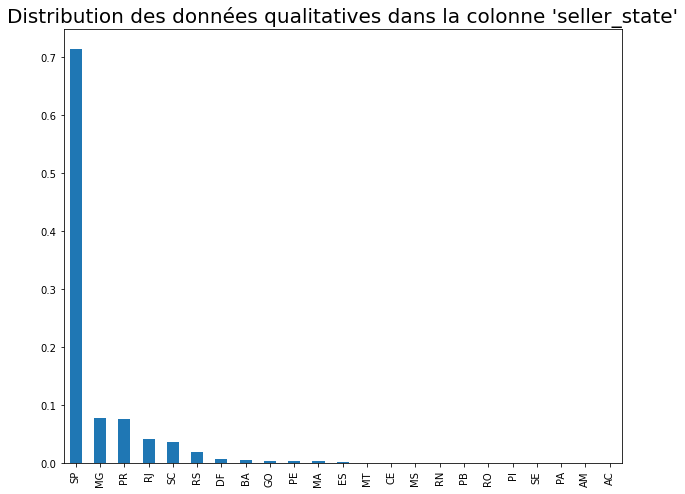

'product_category_name'

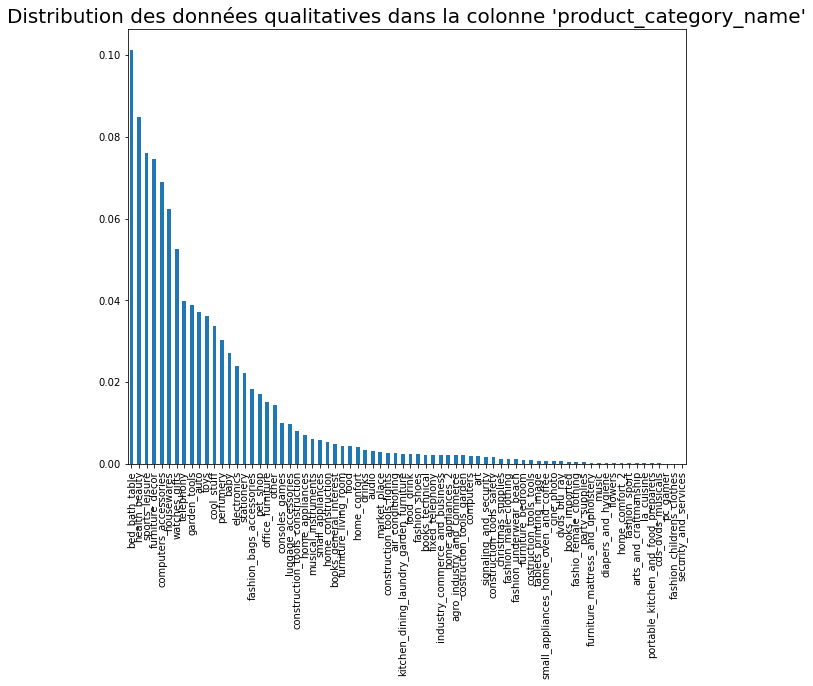

'payment_type'

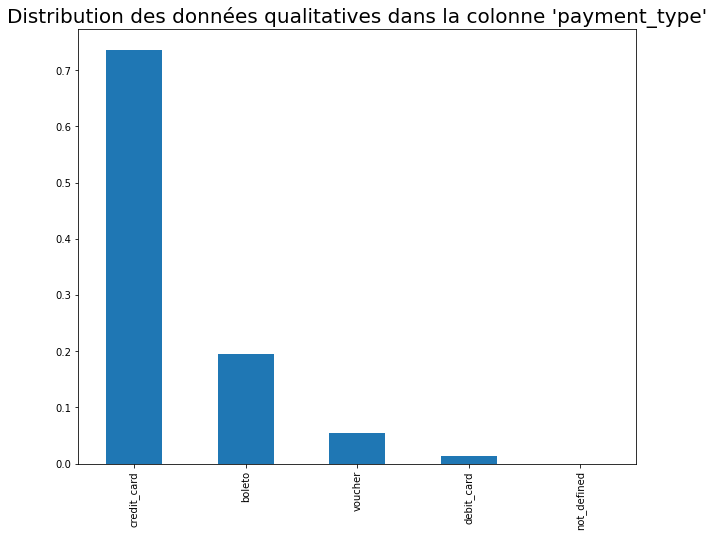

'review_score'

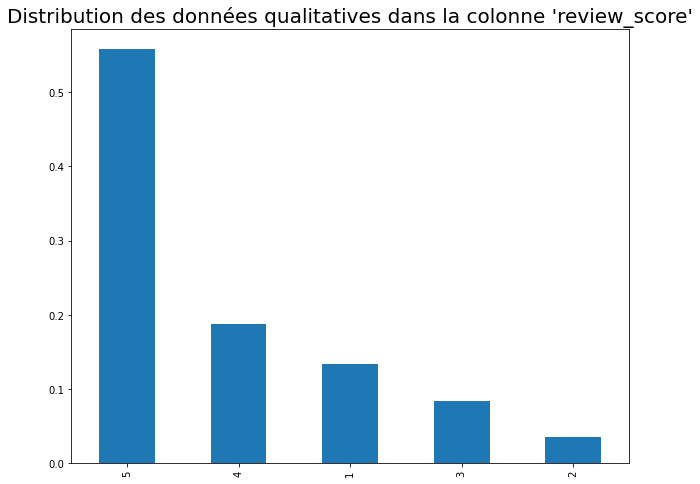

'order_status'

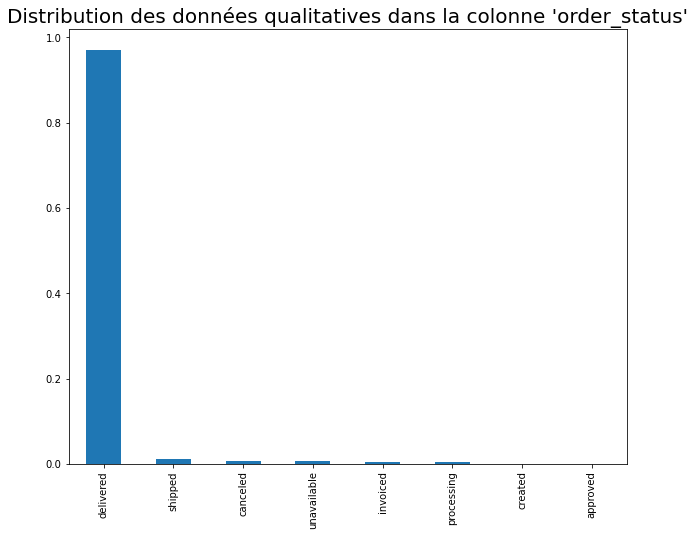

'delivered'

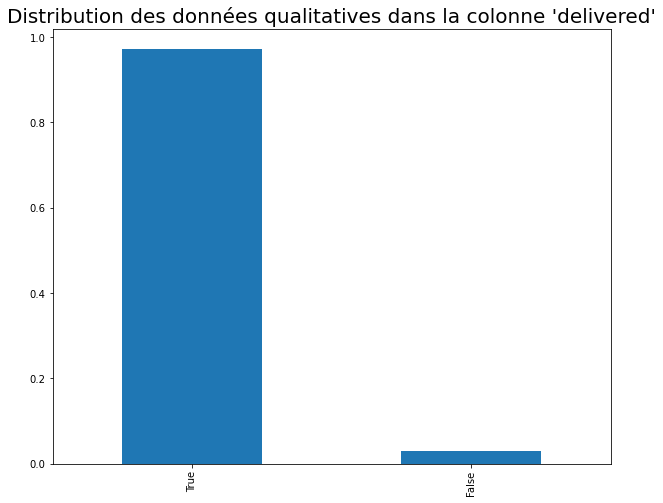

'in_progress'

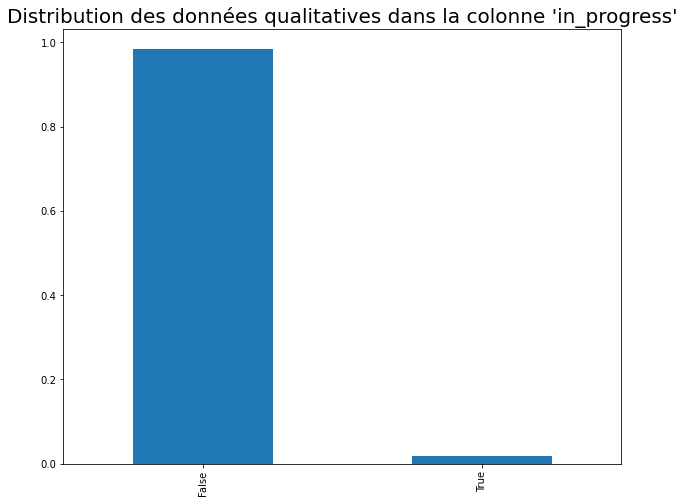

'unavailable'

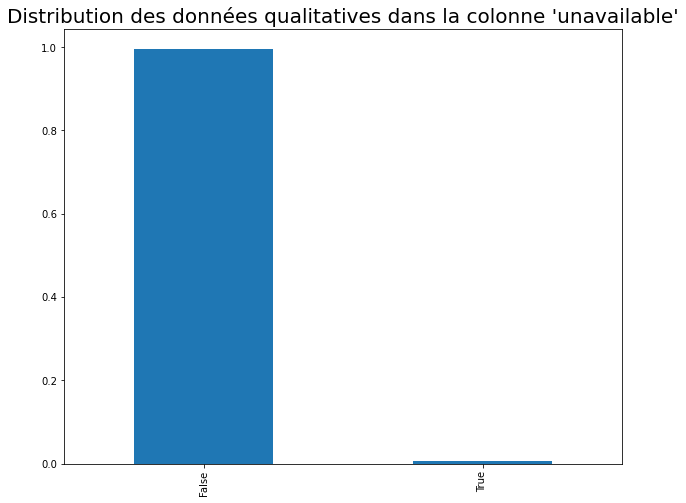

'canceled'

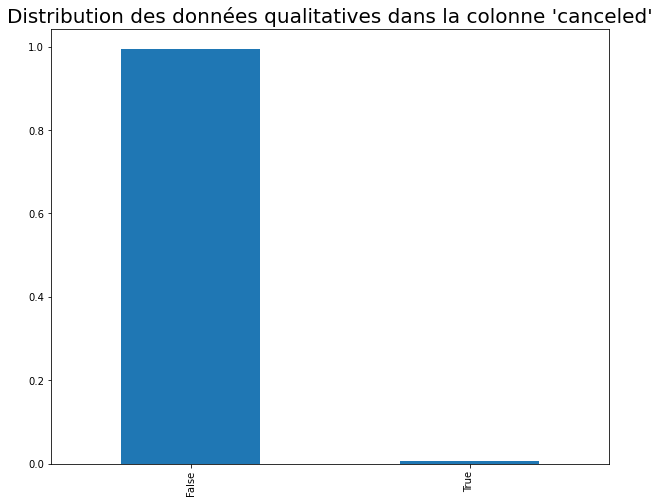

In [46]:
for cat in categ:
    display(cat)
    df_olist_ecommerce[cat].value_counts(normalize=True).plot(kind='bar', figsize=(10,8))
    plt.title(f"Distribution des données qualitatives dans la colonne '{cat}'", fontsize = 20)
    plt.show()

In [47]:
var_discretes = ['payment_sequential', 'payment_installments']

Création du fichier Excel contenant le dataframe

In [48]:
df_olist_ecommerce.to_excel("df_olist_ecommerce.xlsx", index=False)

la suite de l'analyse est dans le notebook POLIST_02_notebookanalyse2.ipynb